In [1]:
#Configuracion de entorno
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))
from src.config import Paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

paths = Paths()

#### EDA

In [2]:
data = pd.read_csv(paths.data_raw_file_online_retail)
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [4]:
data.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


#### Limpieza basica

In [5]:
# Quitamos cancelaciones
noCancelData = data.copy()
noCancelData = noCancelData[~noCancelData['Invoice'].str.startswith('C',na=False)]

# Quitamos cantidades y precios menores que 0
noNegsData = noCancelData.copy()
noNegsData = noNegsData[noNegsData['Quantity'] > 0]
noNegsData = noNegsData[noNegsData['Price'] > 0]

noNegsData.describe()

,Quantity,Price,Customer ID
count,1.041670e+06,1.041670e+06,805549.000000
mean,1.096346e+01,4.076683e+00,15331.954970
std,1.265150e+02,5.144773e+01,1696.737039
min,1.000000e+00,1.000000e-03,12346.000000
25%,1.000000e+00,1.250000e+00,13982.000000
50%,3.000000e+00,2.100000e+00,15271.000000
75%,1.000000e+01,4.130000e+00,16805.000000
max,8.099500e+04,2.511109e+04,18287.000000


#### Convierte tipos de datos

In [6]:
# Convertimos Invoice Date a Datetime y Customer ID a Str

noNegsData.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [7]:
noNegsData['InvoiceDate'] = pd.to_datetime(noNegsData['InvoiceDate'])
noNegsData['Customer ID'] = noNegsData['Customer ID'].astype(str)

noNegsData.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

#### Crear columna de precio total

In [8]:
noNegsData['Total Price'] = noNegsData['Quantity'] * noNegsData['Price']

In [9]:
# Encontramos el cuartil 1 y 3 de cada columna de datos
Q1_Quantity = noNegsData['Quantity'].quantile(0.25)
Q3_Quantity = noNegsData['Quantity'].quantile(0.75)

Q1_TotalPrice = noNegsData['Total Price'].quantile(0.25)
Q3_TotalPrice = noNegsData['Total Price'].quantile(0.75)

# Calculamos el IQR de cada columna
IQR_Quantity = Q3_Quantity - Q1_Quantity
IQR_TotalPrice = Q3_TotalPrice -  Q1_TotalPrice

# Creamos los thresholds para clasificar como outlier
OutMin_Quantity = Q1_Quantity - (1.5* IQR_Quantity)
OutMax_Quantity = Q3_Quantity + (1.5* IQR_Quantity)

OutMin_TotalPrice = Q1_TotalPrice - (1.5 * IQR_TotalPrice)
OutMax_TotalPrice = Q3_TotalPrice + (1.5 * IQR_TotalPrice)


In [10]:
print(f'Consideramos outliers las observaciones cuyas cantidades sean mayores a {round(OutMax_Quantity,0)} o menores a {round(OutMin_Quantity,0)}. \n'
      f'Tambien excluimos aquellas filas que su precio sea mayor a {round(OutMax_TotalPrice,0)} o menor a {round(OutMin_TotalPrice,0)}')

outlierData = noNegsData.copy()

# Creamos un flag para identificar outliers
outlierData['Outlier Flag'] = np.where(
    (outlierData['Quantity'] > OutMax_Quantity) |
    (outlierData['Quantity'] < OutMin_Quantity) |
    (outlierData['Total Price'] > OutMax_TotalPrice) |
    (outlierData['Total Price'] < OutMin_TotalPrice),
    1,
    0
)

# Filtramos la data sin outliers
noOutlierData = outlierData.copy()
noOutlierData = noOutlierData[noOutlierData['Outlier Flag'] !=  1]
noOutlierData.describe()

Consideramos outliers las observaciones cuyas cantidades sean mayores a 24.0 o menores a -12.0. 
Tambien excluimos aquellas filas que su precio sea mayor a 38.0 o menor a -17.0


,Quantity,InvoiceDate,Price,Total Price,Outlier Flag
count,893557.000000,893557,893557.000000,893557.000000,893557.0
mean,4.465765,2011-01-03 20:34:57.254679808,3.377593,10.099805,0.0
min,1.000000,2009-12-01 07:46:00,0.001000,0.001000,0.0
25%,1.000000,2010-07-11 13:34:00,1.250000,3.320000,0.0
50%,2.000000,2010-12-07 15:34:00,2.100000,7.900000,0.0
75%,6.000000,2011-07-24 10:49:00,4.150000,15.300000,0.0
max,23.000000,2011-12-09 12:50:00,38.340000,38.350000,0.0
std,4.203784,NaN,3.353463,8.079197,0.0


In [11]:
noOutlierData.to_parquet(paths.data_processed / "Cleaned Data.parquet", index=False)

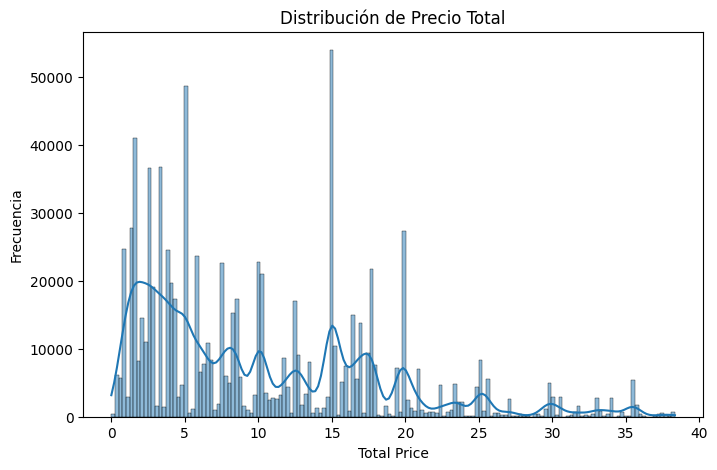

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(noOutlierData['Total Price'], kde=True)
plt.xlabel('Total Price')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precio Total')
plt.show()


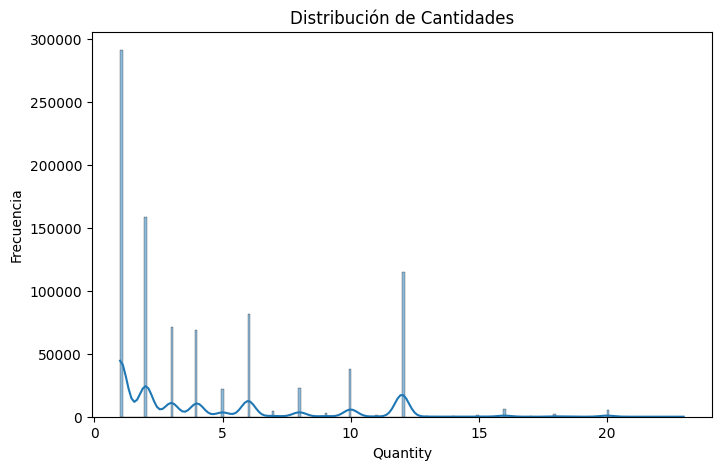

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(noOutlierData['Quantity'], kde=True)
plt.xlabel('Quantity')
plt.ylabel('Frecuencia')
plt.title('Distribución de Cantidades')
plt.show()